Importing Libraries

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.2 MB/s eta 0:00:00


In [ ]:
pip install xgboost

In [ ]:
pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

Loading Datasets

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Kaggle/1_Titanic/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Kaggle/1_Titanic/test.csv")

Exploring Features

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


Data Preprocessing

Prepare Data

In [ ]:
# Set the 'PassengerId' column as the index of data

train.set_index("PassengerId", inplace=True)
test.set_index("PassengerId", inplace=True)

In [ ]:
# 'Cabin' feature is splitted for efficient preprocessing

def convert_cabin(df):
    df[['Deck','CabinNum','CabinSide']] = df['Cabin'].str.split("/", expand=True)
    df.drop('Cabin', axis=1, inplace=True)
    return df

In [ ]:
# Apply on the datasets

train_new = convert_cabin(train)
test_new = convert_cabin(test)

In [ ]:
# Drop columns 'Name','HomePlanet','CabinNum' respectively

train_new.drop(['Name','HomePlanet','CabinNum'],axis=1,inplace=True)
test_new.drop(['Name','HomePlanet','CabinNum'],axis=1,inplace=True)

Handling Null Values

Training Data

In [ ]:
train_new.isnull().sum()

CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Deck            199
CabinSide       199
dtype: int64

In [ ]:
# filling other null values
mode_imp = SimpleImputer(strategy="most_frequent")
mean_imp = SimpleImputer(strategy="mean")

# mode
mode_cols = ['Destination', "CabinSide", "Deck", "CryoSleep","VIP"]
train_new[mode_cols] = mode_imp.fit_transform(train_new[mode_cols].values)

# mean
train_new['Age'] = mean_imp.fit_transform(train_new['Age'].values.reshape(-1,1)).flatten()

In [ ]:
# knn imputer for expenditure columns
exp = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
imputer = KNNImputer()
imputer.fit(train_new[exp])
train_new[exp] = imputer.transform(train_new[exp])

In [ ]:
# set cryosleep to false where some expenditure is present
train_new['Expenditure'] = train_new[exp].sum(axis=1)
train_new.loc[(train_new['CryoSleep'].isnull() & train_new['Expenditure'] > 0), 'CryoSleep'] = False

In [ ]:
train_new.isnull().sum()

CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
CabinSide       0
Expenditure     0
dtype: int64

In [ ]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     8693 non-null   object 
 1   Destination   8693 non-null   object 
 2   Age           8693 non-null   float64
 3   VIP           8693 non-null   object 
 4   RoomService   8693 non-null   float64
 5   FoodCourt     8693 non-null   float64
 6   ShoppingMall  8693 non-null   float64
 7   Spa           8693 non-null   float64
 8   VRDeck        8693 non-null   float64
 9   Transported   8693 non-null   bool   
 10  Deck          8693 non-null   object 
 11  CabinSide     8693 non-null   object 
 12  Expenditure   8693 non-null   float64
dtypes: bool(1), float64(7), object(5)
memory usage: 891.4+ KB


Testing Data

In [ ]:
test_new.isnull().sum()

CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Deck            100
CabinSide       100
dtype: int64

In [ ]:
# filling other null values
mode_imp = SimpleImputer(strategy="most_frequent")
mean_imp = SimpleImputer(strategy="mean")

# mode
mode_cols = ['Destination', "CabinSide", "Deck", "CryoSleep","VIP"]
test_new[mode_cols] = mode_imp.fit_transform(test_new[mode_cols].values)

# mean
test_new['Age'] = mean_imp.fit_transform(test_new['Age'].values.reshape(-1,1)).flatten()

In [ ]:
# knn imputer for expenditure columns
exp = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
imputer = KNNImputer()
imputer.fit(test_new[exp])
test_new[exp] = imputer.transform(test_new[exp])

In [ ]:
# set cryosleep to false where some expenditure is present
test_new['Expenditure'] = test_new[exp].sum(axis=1)
test_new.loc[(test_new['CryoSleep'].isnull() & test_new['Expenditure'] > 0), 'CryoSleep'] = False


In [ ]:
test_new.isnull().sum()

CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Deck            0
CabinSide       0
Expenditure     0
dtype: int64

In [ ]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     4277 non-null   object 
 1   Destination   4277 non-null   object 
 2   Age           4277 non-null   float64
 3   VIP           4277 non-null   object 
 4   RoomService   4277 non-null   float64
 5   FoodCourt     4277 non-null   float64
 6   ShoppingMall  4277 non-null   float64
 7   Spa           4277 non-null   float64
 8   VRDeck        4277 non-null   float64
 9   Deck          4277 non-null   object 
 10  CabinSide     4277 non-null   object 
 11  Expenditure   4277 non-null   float64
dtypes: float64(7), object(5)
memory usage: 434.4+ KB


Now, all the null values are removed. But the datatype is yet to be addressed.

Label Encoding and OneHot Encoding

In [ ]:
#Label Encoding

le = preprocessing.LabelEncoder()



In [ ]:
# One Hot Encoding

def converting_column(df,col,convertType):
    if convertType=='OHE':
        one_hot = pd.get_dummies(df[col],prefix=col)
        df = df.drop(col,axis = 1)
        df = df.join(one_hot)
        return df
    else:
        df[col] = le.fit_transform(df[col])
        return df

In [ ]:
# One Hot Encoding

train_new = converting_column(train_new,'Destination','FTR')
test_new = converting_column(test_new,'Destination','FTR')
train_new = converting_column(train_new,'CryoSleep','FTR')
test_new = converting_column(test_new,'CryoSleep','FTR')
train_new = converting_column(train_new,'VIP','FTR')
test_new = converting_column(test_new,'VIP','FTR')

In [ ]:
# Label Encoding

train_new['Deck'] = le.fit_transform(train_new['Deck'])
train_new['CabinSide'] = le.fit_transform(train_new['CabinSide'])
test_new['Deck'] = le.fit_transform(test_new['Deck'])
test_new['CabinSide'] = le.fit_transform(test_new['CabinSide'])

In [ ]:
train_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     8693 non-null   int64  
 1   Destination   8693 non-null   int64  
 2   Age           8693 non-null   float64
 3   VIP           8693 non-null   int64  
 4   RoomService   8693 non-null   float64
 5   FoodCourt     8693 non-null   float64
 6   ShoppingMall  8693 non-null   float64
 7   Spa           8693 non-null   float64
 8   VRDeck        8693 non-null   float64
 9   Transported   8693 non-null   bool   
 10  Deck          8693 non-null   int64  
 11  CabinSide     8693 non-null   int64  
 12  Expenditure   8693 non-null   float64
dtypes: bool(1), float64(7), int64(5)
memory usage: 891.4+ KB


In [ ]:
test_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4277 entries, 0013_01 to 9277_01
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     4277 non-null   int64  
 1   Destination   4277 non-null   int64  
 2   Age           4277 non-null   float64
 3   VIP           4277 non-null   int64  
 4   RoomService   4277 non-null   float64
 5   FoodCourt     4277 non-null   float64
 6   ShoppingMall  4277 non-null   float64
 7   Spa           4277 non-null   float64
 8   VRDeck        4277 non-null   float64
 9   Deck          4277 non-null   int64  
 10  CabinSide     4277 non-null   int64  
 11  Expenditure   4277 non-null   float64
dtypes: float64(7), int64(5)
memory usage: 434.4+ KB


Train Test Split

In [ ]:
X = train_new.drop('Transported', axis = 1)
y = train_new['Transported']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=82)

In [ ]:
y_test = y_test.astype(int)
y_train = y_train.astype(int)

Building the Model

1) catboost

In [ ]:
cat = CatBoostClassifier(verbose=0, random_state=82)
parameters = {'iterations': [200],
              'learning_rate': [0.1],
              'depth': [5]}

clf = GridSearchCV(cat, parameters, cv=100)
clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

Best parameters: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}
Best score: 0.8098799171842649


In [ ]:
print("score on test: " + str(clf.score(X_test, y_test)))
print("score on train: "+ str(clf.score(X_train, y_train)))

score on test: 0.7981598619896493
score on train: 0.8399482312338222


2)Xgboost

In [ ]:
xg = XGBClassifier(verbose=0, random_state=82)
parameters = {'iterations': [200],
              'learning_rate': [0.1],
              'depth': [5]}

clf2 = GridSearchCV(xg, parameters, cv=100)
clf2.fit(X_train, y_train)

print("Best parameters:", clf2.best_params_)
print("Best score:", clf2.best_score_)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:02:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:02:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:02:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:02:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:02:18] WARNING: /works

Best parameters: {'depth': 5, 'iterations': 200, 'learning_rate': 0.1}
Best score: 0.8080103519668737


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [05:02:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
print("score on test: " + str(clf2.score(X_test, y_test)))
print("score on train: "+ str(clf2.score(X_train, y_train)))

score on test: 0.7901092581943646
score on train: 0.8508771929824561


3) lightgbm

In [ ]:
lightgbm = LGBMClassifier(verbose=0, random_state=82)
parameters = {'iterations': [200],
              'learning_rate': [0.1],
              'depth': [5]}

clf3 = GridSearchCV(lightgbm, parameters, cv=100)
clf3.fit(X_train, y_train)

print("Best parameters:", clf3.best_params_)
print("Best score:", clf3.best_score_)

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
[LightGBM] [Warning] Unknown p

In [ ]:
print("score on test: " + str(clf3.score(X_test, y_test)))
print("score on train: "+ str(clf3.score(X_train, y_train)))

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
score on test: 0.7924094307073031
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
score on train: 0.865545010066149


[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth
Confusion Matrix:
[[673 208]
 [153 705]]


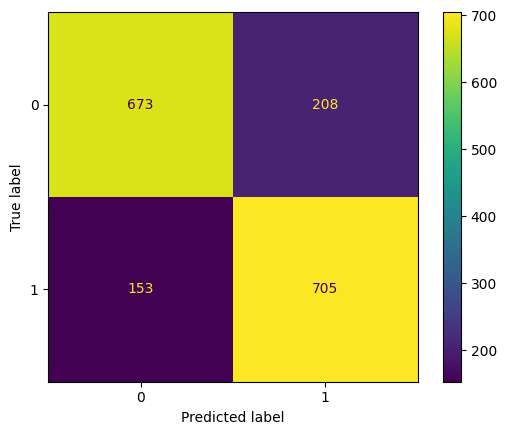

In [ ]:
y_pred = clf3.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       881
           1       0.77      0.82      0.80       858

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



Prediction

In [ ]:
# Make predictions on the test set
predictions = clf3.predict(test_new)

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: depth


In [ ]:
# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    'PassengerId': test.index,
    'Transported': predictions
})

In [ ]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


In [ ]:
submission_df['Transported'].value_counts()

True     2307
False    1970
Name: Transported, dtype: int64

In [ ]:
# Save the predictions to a CSV file
submission_df.to_csv('/content/drive/MyDrive/Kaggle/1_Titanic/submission3.csv', index=False)